# Variational Autoencoders

In [1]:
import torch

In [2]:
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

In [3]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

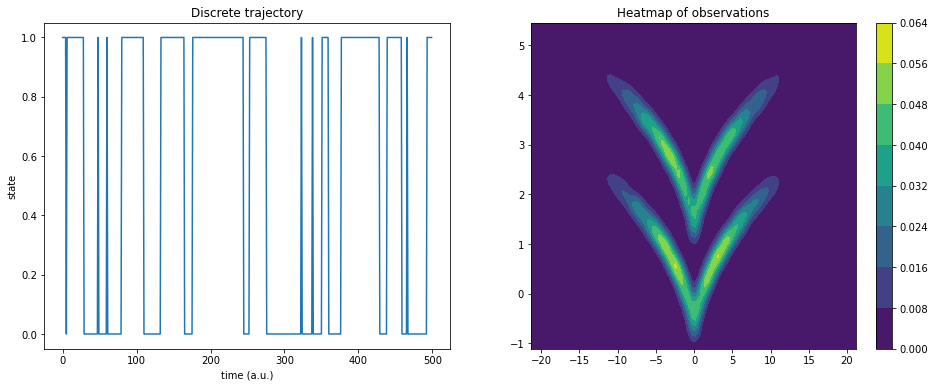

In [4]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

X, Y = np.meshgrid(
    np.linspace(np.min(traj[:, 0]), np.max(traj[:, 0]), 100),
    np.linspace(np.min(traj[:, 1]), np.max(traj[:, 1]), 100),
)
kde_input = np.dstack((X, Y)).reshape(-1, 2)

kernel = stats.gaussian_kde(traj.T, bw_method=0.1)
Z = kernel(kde_input.T).reshape(X.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(dtraj[:500])
ax1.set_title("Discrete trajectory")
ax1.set_xlabel("time (a.u.)")
ax1.set_ylabel("state")

cm = ax2.contourf(X, Y, Z)
plt.colorbar(cm, ax=ax2)
ax2.set_title("Heatmap of observations");

In [5]:
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

dataset = TrajectoryDataset(1, traj.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)

loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [6]:
# to make life more easy, denoise the data

In [7]:
import torch
from deeptime.util.torch import MLP

units = [2, 10, 10, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [8]:
from deeptime.decomposition.deep import TAE

tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=30, validation_loader=loader_val)
tae_model = tae.fetch_model()

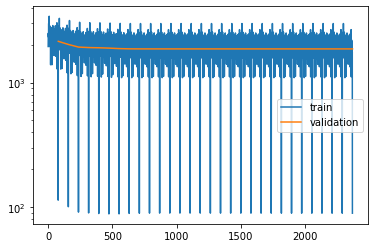

In [9]:
plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.legend();

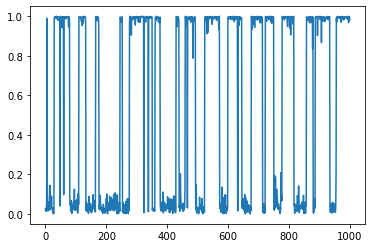

In [10]:
proj = tae_model.transform(traj)
plt.plot(proj[:1000])

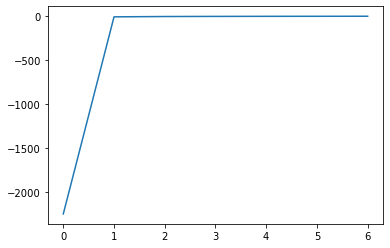

In [11]:
from sklearn.cluster import KMeans

random_state = 42
scores = []
for i in range(1, 7 + 1):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores.append(clf.score(proj))
plt.plot(scores)
plt.show()

# Now real data

In [12]:
import pandas as pd
import json

with open("../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json") as f:
    data = json.load(f)
# time_ser = pd.read_json("Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore_time_series.json")
time_ser = pd.DataFrame(data)
time_ser = time_ser.drop(columns="num_frames")
obs = time_ser.drop_duplicates()
num_obs = len(obs)
print("There are actually ", num_obs, " present.")
obs = obs.to_numpy()
time_ser = time_ser.to_numpy()
print("The length of the observation sequence is ", len(time_ser))

There are actually  77  present.
The length of the observation sequence is  5001


In [13]:
time_ser.shape

(5001, 11)

In [14]:
dataset = TrajectoryDataset(1, time_ser.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)
print(len(val_data))
loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

2500


In [15]:
num_superfeatures = len(obs[0])

In [16]:
units = [num_superfeatures, 4 * num_superfeatures, 4 * num_superfeatures, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)

In [17]:
tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=50, validation_loader=loader_val)
tae_model = tae.fetch_model()

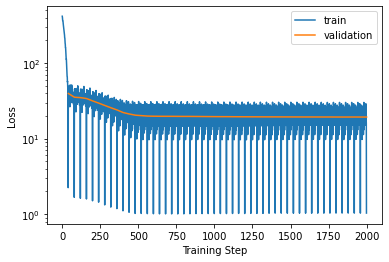

In [18]:
plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend();

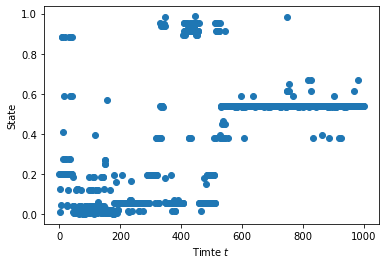

In [19]:
proj = tae_model.transform(time_ser)
plt.ylabel("State")
plt.xlabel("Timte $t$")
plt.scatter(np.arange(0, 1000, 1), proj[:1000])

# Cluster for Distinct States

In [20]:
from sklearn.cluster import KMeans
from tqdm import tqdm

random_state = 42
scores = np.zeros(16)
sum_of_squared_distances = np.zeros(16)
for i in range(1, 15):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores[i] = clf.score(proj)
    sum_of_squared_distances[i] = clf.inertia_

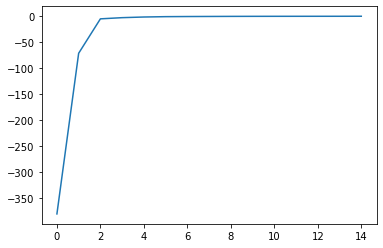

In [21]:
plt.plot(scores[1:])

In [22]:
len(np.unique(proj))
metric = np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0])

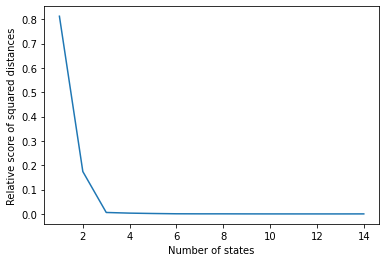

In [67]:
diff = np.abs(np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0]))
plt.plot(np.arange(1, len(diff) + 1, 1), diff)
plt.xlabel("Number of states")
plt.ylabel("Relative score of squared distances")
plt.savefig("ZIKA_ellbow.png", dpi=300)

In [24]:
metric

array([-8.12636901e-01, -1.74198627e-01, -5.98591318e-03, -3.31197937e-03,
       -1.78003967e-03, -6.26189125e-04, -3.89958450e-04, -3.74096127e-04,
       -2.07630188e-04, -1.14255425e-04, -7.85484945e-05, -6.71068098e-05,
       -6.64847814e-05, -1.62270692e-04])

(array([   8,    9,   17, ..., 4998, 4999, 5000]),)
[False False False ...  True  True  True]


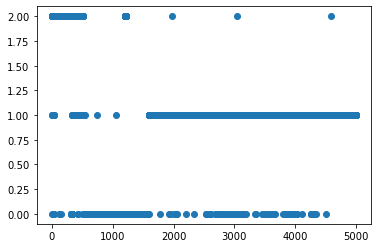

In [26]:
# get labels
clf = KMeans(n_clusters=3, random_state=random_state).fit(proj)
labels = clf.labels_
plt.scatter(np.arange(0, len(time_ser), 1), labels)
print(np.where(labels.astype(int) == 1))
print(labels == 1)

In [35]:
np.save("labels_1KE7", labels)

# Fit MSM to Discretization

For HMM see: https://deeptime-ml.github.io/latest/api/generated/deeptime.markov.hmm.BayesianHMMPosterior.html#deeptime.markov.hmm.BayesianHMMPosterior

In [27]:
import numpy as np
from deeptime.markov import TransitionCountEstimator

estimator = TransitionCountEstimator(lagtime=1, count_mode="sliding")

In [28]:
counts = estimator.fit(labels).fetch_model()  # fit and fetch the model

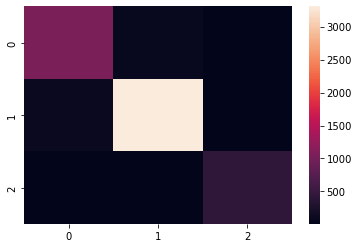

In [62]:
import seaborn as sns

ax = sns.heatmap(counts.count_matrix)
fig = ax.get_figure()
fig.savefig("ZIK_count_matrix.png", dpi=300)

In [30]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True, stationary_distribution_constraint=None
)

msm = estimator.fit(counts).fetch_model()

In [31]:
print("Estimated transition matrix:", msm.transition_matrix)
print("Estimated stationary distribution:", msm.stationary_distribution)

Estimated transition matrix: [[0.91027875 0.07688461 0.01283665]
 [0.02576695 0.97092511 0.00330794]
 [0.0341466  0.02625608 0.93959732]]
Estimated stationary distribution: [0.22936973 0.68440388 0.08622639]


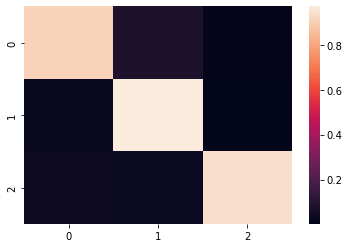

In [57]:
ax = sns.heatmap(msm.transition_matrix)
fig = ax.get_figure()
fig.savefig("Zika_tae.png", dpi=300)

# Fit HMM to Discretization & Raw Data

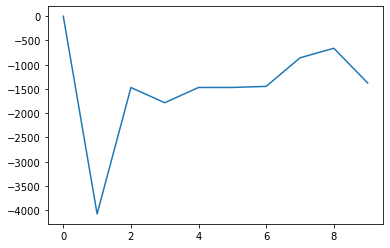

In [33]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder


def calculate_probas(time_ser, model):
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1, num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except:
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

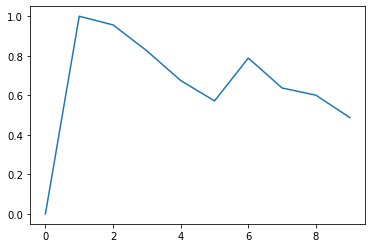

In [34]:
plt.plot(probas)

In [35]:
def proba_per_state(time_ser, model):
    """ """
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    prob_ser = np.zeros(probas.shape)
    for i in range(len(states)):
        prob_ser[i, states[i]] = probas[i, states[i]]
    return prob_ser


model = hmm.MultinomialHMM(n_components=4)
labels = labels.reshape(-1, 1)
model.fit(labels)
result = model.predict(labels)
print(labels[:10])
test = proba_per_state(labels, model)[:2000]

[[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]]


In [36]:
probas = model.predict_proba(labels)

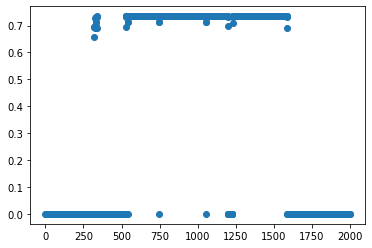

In [37]:
plt.scatter(np.arange(0, len(test), 1), test[:, 0])

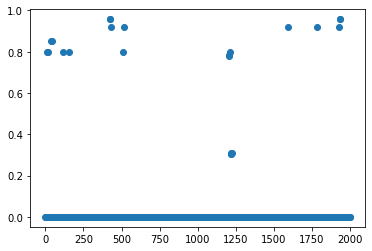

In [38]:
plt.scatter(np.arange(0, len(test), 1), test[:, 1])

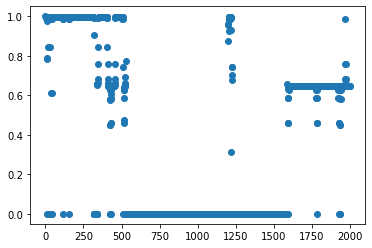

In [39]:
plt.scatter(np.arange(0, len(test), 1), test[:, 2])

In [40]:
def aic(scores):
    return -2 * scores - 2 * np.arange(1, 11, 1)

In [41]:
aic = aic(scores)

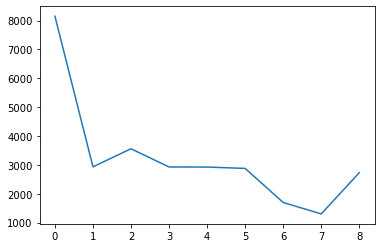

In [42]:
plt.plot(aic[1:])

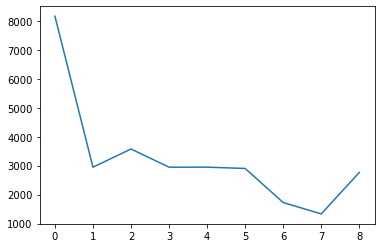

In [43]:
def bic(scores):
    return -2 * scores + np.arange(1, 11, 1) + np.log(len(scores))


bic = bic(scores)
plt.plot(bic[1:])

In [44]:
probas = model.predict_proba(time_ser)
np.mean(np.linalg.norm(probas, axis=1))

0.7581689692113758

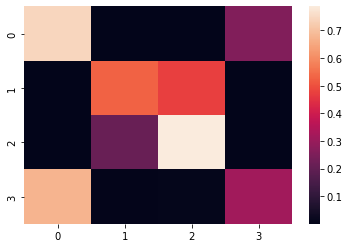

In [45]:
ax = sns.heatmap(model.transmat_)

# HMM on the whole trajectory

In [49]:
def label_traj(time_ser, obs):
    reduced_time_ser = np.zeros(len(time_ser))
    for i in range(len(time_ser)):
        for j in range(len(obs)):
            if compare_array(time_ser[i], obs[j]):
                reduced_time_ser[i] = j
                break
    return reduced_time_ser.astype(np.int64)


def compare_array(arr1, arr2):
    comp = arr1 == arr2
    return comp.all()


red_time_ser = label_traj(time_ser, obs)

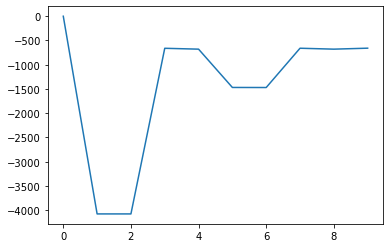

In [50]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder


def calculate_probas(time_ser, model):
    probas = model.predict_proba(time_ser)
    states = model.predict(time_ser)
    return np.mean(np.linalg.norm(probas, axis=1))


num_sim = 10
scores = np.zeros(num_sim)
probas = np.zeros(num_sim)
labels = labels.reshape(-1, 1)
for i in range(1, num_sim):
    model = hmm.MultinomialHMM(n_components=i)
    try:
        pred = model.fit(labels)
        scores[i] = model.score(labels)
        probas[i] = calculate_probas(time_ser, model)
    except:
        scores[i] = 0
        probas[i] = 0
plt.cla()
plt.clf()
plt.plot(scores)

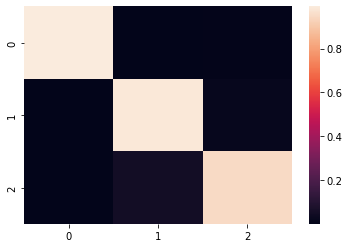

In [61]:
model = hmm.MultinomialHMM(n_components=3)
red_time_ser = red_time_ser.reshape(-1, 1)
model.fit(red_time_ser)
result = model.predict(red_time_ser)
ax = sns.heatmap(model.transmat_)
fig = ax.get_figure()
fig.savefig("Zika_HMM.png", dpi=300)